### Import modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional

### Helper functions

In [15]:
def substitution(read: np.ndarray, p: float = 0.1) -> np.ndarray: 
    has_substitution = np.random.uniform(low=0.0, high=1.0, size=read.size) < p
    random_substitution = np.random.randint(low=1, high=4, size=read.size)
    corrupted_read = (read + has_substitution*random_substitution) % 4
    return corrupted_read

def insertion(read: np.ndarray, p: float = 0.1) -> np.ndarray:
    """ The geometric distribution is the distribution for the number of attempt to get the first success:
        p * (1-p)^(k-1)  for k=1,2,...
        In our case 'success' is the presence of an insertion which happens with probability p. 
        Therefore the geometric distribution describes how many bases I need to wait before the next insertion
    """
    read_list = read.tolist()
    current_loc=np.random.geometric(p=p, size=1).item()-1  # location of first insertion
    
    while current_loc <= len(read_list):  # note the equal sign since you can add base at the very end
        base_to_insert = np.random.randint(low=0, high=4, size=1).item()
        read_list.insert(current_loc, base_to_insert)
        # Note that here there is NO -1. This is different from deletion function
        current_loc += np.random.geometric(p=p, size=1).item()  # location of next insertion
    return np.array(read_list)


def deletion(read: np.ndarray, p: float = 0.1) -> np.ndarray:
    """ The geometric distribution is the distribution for the number of attempt to get the first success: 
        p * (1-p)^(k-1)  for k=1,2,...
        In our case 'success' is the presence of a deletion which happens with probability p. 
        Therefore the geometric distribution describes how many bases I need to wait before the next deletion
    """
    read_list = read.tolist()
    current_loc=np.random.geometric(p=p, size=1).item()-1  # location of first deletion
    
    while current_loc < len(read_list): 
        del read_list[current_loc]
        # Note the -1 so that consecutive bases can be deleted
        current_loc += np.random.geometric(p=p, size=1).item()-1  # location of next deletion.  
    return np.array(read_list)

def make_one_hot(read: np.ndarray) -> np.ndarray:
    """ ACTG are represented as one_hot vector """
    one_hot = np.zeros((read.size,4), dtype=int) 
    for n in (0,1,2,3):
        one_hot[(read == n),n]=1
    return one_hot

def create_read(L_read: int = 100, N_repeat: int = 3) -> np.ndarray:
    base_read = np.random.randint(low=0, high=4, size=L_read, dtype=int)  # 0,1,2,3 respesents A,C,T,G
    return np.tile(base_read, N_repeat)

def sliding_correlation(read: np.ndarray, 
                        template: np.ndarray, 
                        smooth_kernel: Optional[np.ndarray] = None) -> np.ndarray:
    """ Correlation between template and read when the template start at the position i of the read """
    l = template.size
    correlation = np.zeros(read.size, dtype=float)
    
    template_one_hot = make_one_hot(template)
    read_one_hot = make_one_hot(read)
    
    if smooth_kernel is not None:
        read_one_hot = smooth_one_hot(one_hot_read=read_one_hot, smooth_kernel=smooth_kernel)
        
    for n in range(read.size):
        shifted_read_one_hot = np.roll(read_one_hot, shift=n, axis=0)[:template.size]
        correlation[n] = np.sum(shifted_read_one_hot*template_one_hot) 
    return correlation

def smooth_one_hot(one_hot_read: np.ndarray, smooth_kernel: np.ndarray) -> np.ndarray:
    smooth_kernel = smooth_kernel/sum(smooth_kernel)
    smoothed = np.zeros(one_hot_read.shape, dtype=float)
    for n in (0,1,2,3):
        smoothed[:, n] = np.convolve(one_hot_read[:,n], smooth_kernel, mode='same')
    return smoothed



## If read is perfect correlation can be used to identify beginning of read

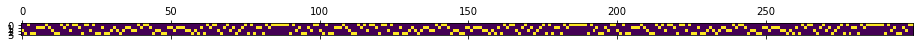

In [40]:
perfect_read = create_read(L_read = 100, N_repeat = 3)
one_hot = make_one_hot(perfect_read)
_ = plt.matshow(one_hot.T)

Text(0.5, 1.0, 'Correlation with the template as a function of genomic coordinate')

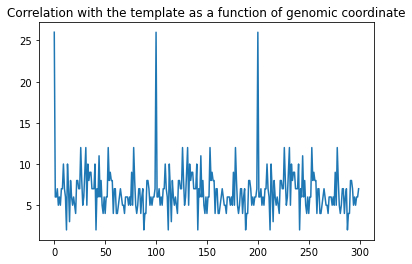

In [41]:
a = sliding_correlation(perfect_read, template=perfect_read[:26])
plt.plot(a)
plt.title("Correlation with the template as a function of genomic coordinate")

## If read had frame shifts auto_correlation can NOT identify the beginning of read

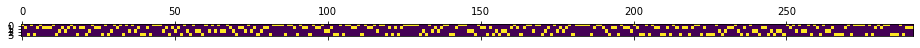

In [18]:
p_deletion = 0.1
p_insertion = 0.1
p_substitution = 0.1
tmp_read = deletion(perfect_read, p=p_deletion)
tmp_read = insertion(tmp_read, p=p_insertion)
imperfect_read = substitution(tmp_read, p=p_substitution)

one_hot = make_one_hot(imperfect_read)
_ = plt.matshow(one_hot.T)

Text(0.5, 1.0, 'Correlation with the template as a function of genomic coordinate')

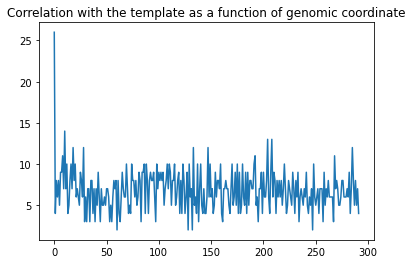

In [39]:
a = sliding_correlation(imperfect_read, template=imperfect_read[:26])
plt.plot(a)
plt.title("Correlation with the template as a function of genomic coordinate")

## Idea. Smooth out the read before computing the correlation

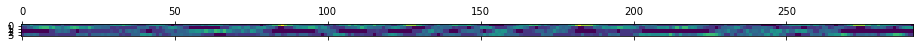

In [37]:
smooth_kernel = np.array([0.8,0.8,0.8,1.0,0.8,0.8,0.8])

one_hot = make_one_hot(imperfect_read)
one_hot_smoothed = smooth_one_hot(one_hot, smooth_kernel=smooth_kernel)
_ = plt.matshow(one_hot_smoothed.T)

Text(0.5, 1.0, 'Correlation with the template as a function of genomic coordinate')

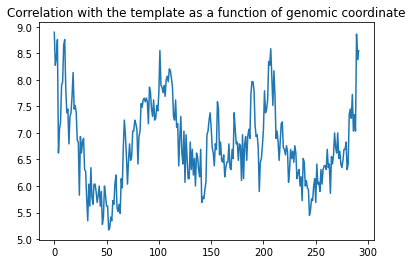

In [38]:
a = sliding_correlation(imperfect_read, template=imperfect_read[:26], smooth_kernel=smooth_kernel)
plt.plot(a)
plt.title("Correlation with the template as a function of genomic coordinate")